### Problem description ###
This project seeks to build a model that can predict whether or not tweets are about real disasters or not. It will do this by participating in the kaggle competition here: https://www.kaggle.com/c/nlp-getting-started/overview. We will investigate various NLP models, include simpleRNN, LSTM, and GRU. This notebook is contained at : https://github.com/Jakagie/NLP-Disaster

In [63]:
# basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import os
import nltk
#import cv2
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, Dense, GRU


### Data Import ###

In [64]:
train_df = pd.read_csv("nlp-getting-started/train.csv")
test_df = pd.read_csv("nlp-getting-started/test.csv")

In [65]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [66]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [67]:
print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


4342 3271 7613
0.5703402075397347 0.4296597924602653


Text(0.5, 1.0, 'Number of Tweets by disaster code')

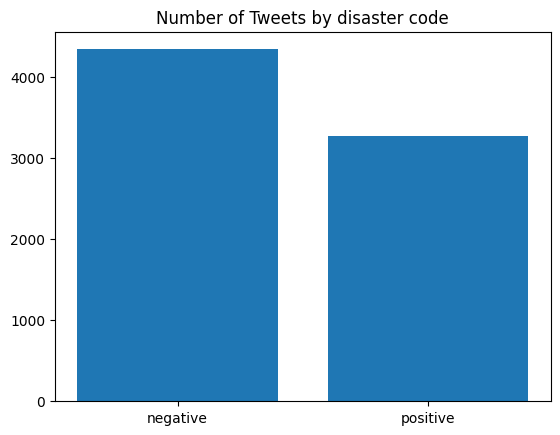

In [68]:
negatives = len(train_df[train_df["target"]== 0])
positives = len(train_df[train_df["target"]== 1])
total = negatives + positives
print(negatives, positives, total)
print(negatives / total, positives / total)

plt.bar(x = ["negative", "positive"], height = [negatives, positives])
plt.title("Number of Tweets by disaster code")

As you can see, the data is in the format of id, keyword, location, text, and possibly target depending on train or test. There are around 7.6 thousand in the training set and 3.2 thousand tweets in the test set. About 57% are negative, 43% are positive. While these are not perfectly even, it is close enough that the data will not be curated to be even.

### Data Cleaning / Pre-Processing ###

We are going to clean and process the data by splitting it into train and test. Then we are going to make a corpus for use with GloVe. Finally, we are goingg to embed with GloVe.

Let's split the training data into test and train data.

In [69]:
x = train_df["text"]
y = train_df["target"]
x_test = test_df["text"]

x_train , x_val, y_train, y_val = train_test_split(x,y, test_size = 0.2, random_state = 42)


For this project, we are going to be using GloVe embeddings. They work by creating vector representations for words where the distances between words are based on their semantic similarity. It involves first making a corpus that can then be used to determine co-occurence statistics (source: https://en.wikipedia.org/wiki/GloVe). The below code for GloVe embeddings is inspired by an example of GloVe embedding from a different kaggle contest here: https://www.kaggle.com/code/shivam017arora/imdb-sentiment-analysis. The embedding relies on pre-trained word vectors. We are going to be using the Twitter version with 100 dimensions. 

In [70]:
corpus = []
for text in train_df["text"]:
    words = [word.lower() for word in word_tokenize(text)]
    corpus.append(words)

In [71]:
num_words = len(corpus)
print(num_words)

7613


In [72]:
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen = 32, truncating = 'post', padding = 'post')

x_val = tokenizer.texts_to_sequences(x_val)
x_val = pad_sequences(x_val, maxlen = 32, truncating = 'post', padding = 'post')

x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen = 32, truncating = 'post', padding = 'post')

In [73]:
word_index = tokenizer.word_index
print(f"Number of unique words: {len(word_index)}")

Number of unique words: 19459


Here is where the embedding step will fully occur. 

In [74]:
embedding = {}
with open("glove.twitter.27B/glove.twitter.27B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
file.close()

In [75]:
embedding_matrix = np.zeros((num_words+1, 100))
for i, word in tokenizer.index_word.items():
    if i < (num_words+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

### Modeling  and Iteration ###
Now that the preprocessing and encoding has been completed, its time to make a model. First we are going to make a very simple model using a basic RNN. Then we are going to contrast that with an LSTM model to see the differences in efficacy. After that, we will check a GRU model. Throughout, we will test various learning rates and Epoch amounts.

In [76]:
#RNN

model = Sequential()
model.add(Embedding(input_dim = num_words+1,
                    output_dim = 100,
                    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                    trainable = False))
model.add(SimpleRNN(100))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [77]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [78]:
rnn_history = model.fit(x_train, y_train, epochs = 25, batch_size = 256, validation_data = (x_val, y_val))

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6031 - loss: 0.6540 - val_accuracy: 0.7006 - val_loss: 0.5969
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6884 - loss: 0.6150 - val_accuracy: 0.7623 - val_loss: 0.5524
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7494 - loss: 0.5616 - val_accuracy: 0.7472 - val_loss: 0.5562
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7415 - loss: 0.5706 - val_accuracy: 0.7636 - val_loss: 0.5493
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7379 - loss: 0.5728 - val_accuracy: 0.7708 - val_loss: 0.5407
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7521 - loss: 0.5626 - val_accuracy: 0.7741 - val_loss: 0.5301
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7605 - loss: 0.5440 - val_accuracy: 0.7656 - val_loss: 0.5400
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7651 - loss: 0.5417 - val_accuracy: 0.6776 - val_loss

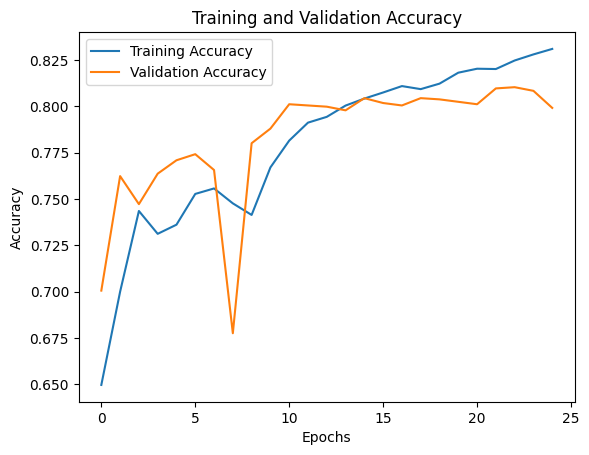

In [79]:
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

As seen in the graph, the training accuracy steadily increases the higher up in epochs we go. However, the validation accuracy remains steady after around epoch 10. As such, we will lower the number of epochs to avoid overtraining. Right now we will also try lowering the learning rate to see any differences.

In [80]:
#RNN
model = Sequential()
model.add(Embedding(input_dim = num_words+1,
                    output_dim = 100,
                    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                    trainable = False))
model.add(SimpleRNN(100))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics = ["accuracy"])

rnn_slower_history = model.fit(x_train, y_train, epochs = 25, batch_size = 256, validation_data = (x_val, y_val))

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5513 - loss: 0.6879 - val_accuracy: 0.6172 - val_loss: 0.6557
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6155 - loss: 0.6559 - val_accuracy: 0.6494 - val_loss: 0.6206
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6602 - loss: 0.6169 - val_accuracy: 0.6901 - val_loss: 0.5942
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6995 - loss: 0.5884 - val_accuracy: 0.7183 - val_loss: 0.5751
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7164 - loss: 0.5682 - val_accuracy: 0.7157 - val_loss: 0.5637
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7226 - loss: 0.5568 - val_accuracy: 0.7531 - val_loss: 0.5426
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7345 - loss: 0.5457 - val_accuracy: 0.7551 - val_loss: 0.5301
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7573 - loss: 0.5185 - val_accuracy: 0.7708 - val_loss

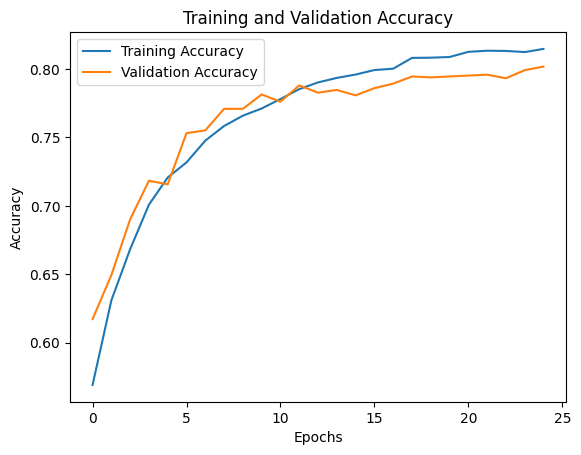

In [81]:
plt.plot(rnn_slower_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_slower_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

This seems to have lead to a slower increasing training accuracy as well as a higher and more stable validation accuracy. We will use this training rate going forward. For this training aspeed we will continue with an epoch of around 12 to avoid overfitting.

Now let's move on and test an LSTM model.

In [86]:
model = Sequential()
model.add(Embedding(input_dim = num_words+1,
                    output_dim = 100,
                    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                    trainable = False))
model.add(SimpleRNN(100))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics = ["accuracy"])

rnn_slower_history = model.fit(x_train, y_train, epochs = 12, batch_size = 256, validation_data = (x_val, y_val))

Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5472 - loss: 0.6876 - val_accuracy: 0.6323 - val_loss: 0.6509
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6360 - loss: 0.6440 - val_accuracy: 0.6691 - val_loss: 0.6032
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6753 - loss: 0.6018 - val_accuracy: 0.7426 - val_loss: 0.5465
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7308 - loss: 0.5478 - val_accuracy: 0.7590 - val_loss: 0.5227
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7445 - loss: 0.5290 - val_accuracy: 0.7669 - val_loss: 0.5083
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7619 - loss: 0.5193 - val_accuracy: 0.7715 - val_loss: 0.5020
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7793 - loss: 0.4955 - val_accuracy: 0.7768 - val_loss: 0.4929
Epoch 8/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7855 - loss: 0.4834 - val_accuracy: 0.7774 - val_loss

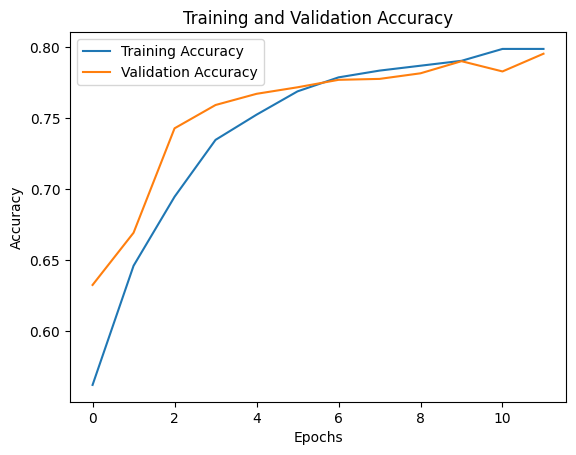

In [87]:
plt.plot(rnn_slower_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_slower_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [96]:
#LSTM

model = Sequential()
model.add(Embedding(input_dim = num_words+1,
                    output_dim = 100,
                    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                    trainable = False))
model.add(LSTM(100))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics = ["accuracy"])

In [97]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [98]:
lstm_history = model.fit(x_train, y_train, epochs = 10, batch_size = 256, validation_data = (x_val, y_val))

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5107 - loss: 0.6930 - val_accuracy: 0.5739 - val_loss: 0.6869
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5696 - loss: 0.6844 - val_accuracy: 0.5772 - val_loss: 0.6757
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5905 - loss: 0.6679 - val_accuracy: 0.6888 - val_loss: 0.6379
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7032 - loss: 0.6181 - val_accuracy: 0.7150 - val_loss: 0.5692
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7288 - loss: 0.5457 - val_accuracy: 0.7892 - val_loss: 0.4901
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7786 - loss: 0.4898 - val_accuracy: 0.7905 - val_loss: 0.4650
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8007 - loss: 0.4513 - val_accuracy: 0.8004 - val_loss: 0.4560
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8028 - loss: 0.4466 - val_accuracy: 0.7991 - val_loss

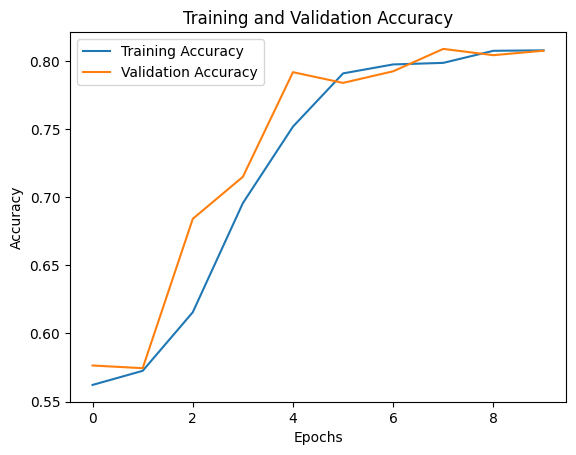

In [91]:
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

This model seems to be performing similarly to the SimpleRRN model, ending up at an accuracy of about 0.8 for validation and training.

Let's check a GRU model.

In [105]:
#GRU

model = Sequential()
model.add(Embedding(input_dim = num_words+1,
                    output_dim = 100,
                    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                    trainable = False))
model.add(GRU(100))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics = ["accuracy"])

In [106]:
gru_history = model.fit(x_train, y_train, epochs = 15, batch_size = 256, validation_data = (x_val, y_val))

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5698 - loss: 0.6924 - val_accuracy: 0.5739 - val_loss: 0.6899
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5570 - loss: 0.6896 - val_accuracy: 0.5739 - val_loss: 0.6867
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5755 - loss: 0.6853 - val_accuracy: 0.5739 - val_loss: 0.6836
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5760 - loss: 0.6814 - val_accuracy: 0.5739 - val_loss: 0.6805
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5753 - loss: 0.6785 - val_accuracy: 0.5745 - val_loss: 0.6756
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5712 - loss: 0.6726 - val_accuracy: 0.5968 - val_loss: 0.6568
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6304 - loss: 0.6427 - val_accuracy: 0.6848 - val_loss: 0.6144
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6745 - loss: 0.6019 - val_accuracy: 0.7360 - val_loss

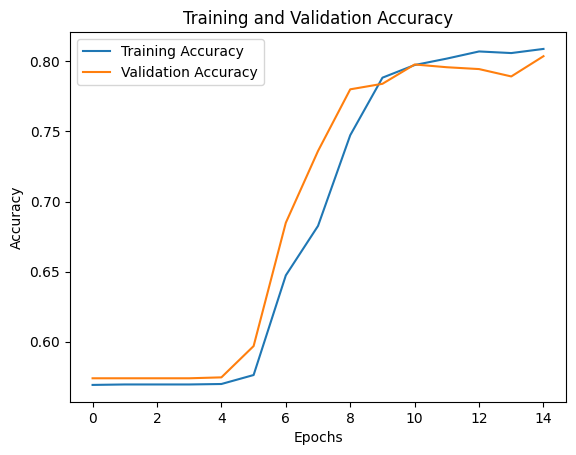

In [107]:
plt.plot(gru_history.history['accuracy'], label='Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

This one also seems to stabalize around a validation and training accuracy of 0.8

### Analysis ###
Let's compare our models against each other.

In [108]:
rnn_acc = rnn_history.history["val_accuracy"][-1]
rnn_slower_acc = rnn_slower_history.history["val_accuracy"][-1]
lstm_acc = lstm_history.history["val_accuracy"][-1]
gru_acc = gru_history.history["val_accuracy"][-1]

print(f"RNN validation accuracy: {rnn_acc}")
print(f"Slower RNN validation accuracy: {rnn_slower_acc}")
print(f"LSTM model validation accuracy: {lstm_acc}")
print(f"GRU model validation accuracy: {gru_acc}")

RNN validation accuracy: 0.7990807890892029
Slower RNN validation accuracy: 0.7951411604881287
LSTM model validation accuracy: 0.8017071485519409
GRU model validation accuracy: 0.803676962852478


While these are all close, the GRU model has the highest validation accuracy. As such, I will use that as my submission.

Most of the models performed similarly. As shown above, iterating on number of epochs, training rate, and model type did lead to marginal improvements. The first model had a validation accuracy of .799, whereas our last model was up to .804. Main things that helped were lowering the training rate. It lowered the amount of jumping withing accuracy scores and lead to a smoother fit. Controlling the epoch count lead to a reduction of overfitting.

The rest of the detailed analyis is above, with going through each model by epoch and training rate.

### Conclusion ###

Overall, this gave me a great introduction into how NLP works. I learned quite a bit about how encodings work and in particular how GloVe works. Beyond that, at this level of encoding it seemed like most of the models worked to a similar level of efficacy once tuned. Granted, the models did work in the order I expected them to, but the differences were marginal. I was surprised at the lack of performance differences between the models and thought the gap would be considerably wider than it was.

Major takeways from this project would be: NLP can be incredibly powerful even at this level. It makes me want to learn more about transformers and things like LLM. 

Future ideas: going through and more rigorously pruning the dataset could lead to better performance. Removing extraneous information or words as well as attempting different methods of encoding could potentially lead to better performance.

### Submission ###

Let's finally make our submission.

In [109]:
sample_sub=pd.read_csv('nlp-getting-started/sample_submission.csv')

In [110]:
y_pre=model.predict(x_test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
